In [0]:
#Mount the google drive:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Check the directory:
cd /content/drive/My Drive/Colab Notebooks/Six_Classes

/content/drive/My Drive/Colab Notebooks/Six_Classes


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input, decode_predictions


Using TensorFlow backend.


In [0]:
WIDTH=224
HEIGHT=224
BATCH_SIZE=64
test_dir = 'test/'
train_dir = 'train/'
val_dir = 'val/'

In [0]:
#Train DataSet Generator with Augmentation
print("\nTraining Data Set")
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_flow = train_generator.flow_from_directory(
    train_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)



Training Data Set
Found 11235 images belonging to 6 classes.


In [0]:
#Validation DataSet Generator with Augmentation
print("\nValidation Data Set")
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
val_flow = val_generator.flow_from_directory(
    val_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)


Validation Data Set
Found 622 images belonging to 6 classes.


In [0]:
#Test DataSet Generator with Augmentation
print("\nTest Data Set")
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_flow = test_generator.flow_from_directory(
    test_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE
)


Test Data Set
Found 1256 images belonging to 6 classes.


In [0]:
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from keras import optimizers, models
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras import applications
from keras import backend as K
import tensorflow as tf
import os


In [0]:
NUM_PARALLEL_EXEC_UNITS = 8

In [0]:
#Set Performance Parameters for MKL and Tensorflow using Keras backend
#TensorFlow
config = tf.ConfigProto(
    intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS,
    inter_op_parallelism_threads=1
)

In [0]:
session = tf.Session(config=config)
K.set_session(session)


In [0]:
#MKL and OpenMP
os.environ["OMP_NUM_THREADS"] = str(NUM_PARALLEL_EXEC_UNITS)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

In [0]:
# Initialize VGG16 with transfer learning
base_model = applications.VGG16(weights='imagenet', 
                                include_top=False, 
                                input_shape=(WIDTH, HEIGHT,3))






58892288/58889256 [==============================] - 1s 0us/step






In [0]:
# add a global spatial average pooling layer
x = base_model.output

In [0]:
x = GlobalAveragePooling2D()(x)
# and a dense layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_flow.class_indices), activation='softmax')(x)

In [0]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False


In [0]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy', 'top_k_categorical_accuracy'], loss='categorical_crossentropy')
model.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0 

In [0]:
import math
top_layers_file_path="top_layers.vgg16.hdf5"


In [0]:
checkpoint = ModelCheckpoint(top_layers_file_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
tb = TensorBoard(log_dir='./logs', batch_size=val_flow.batch_size, write_graph=True, update_freq='batch')
early = EarlyStopping(monitor="loss", mode="min", patience=5)
csv_logger = CSVLogger('./logs/vgg16-log.csv', append=True)

In [0]:
history = model.fit_generator(train_flow, 
                              epochs=3, 
                              verbose=1,
                              validation_data=val_flow,
                              validation_steps=math.ceil(val_flow.samples/val_flow.batch_size),
                              steps_per_epoch=math.ceil(train_flow.samples/train_flow.batch_size),
                              callbacks=[checkpoint, early, tb, csv_logger])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Epoch 1/3
  1/176 [..............................] - ETA: 2:39:42 - loss: 4.8683 - acc: 0.1562 - top_k_categorical_accuracy: 0.8281WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1265: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.

176/176 [==============================] - 6063s 34s/step - loss: 0.4321 - acc: 0.8970 - top_k_categorical_accuracy: 0.9899 - val_loss: 1.9332 - val_acc: 0.5193 - val_top_k_categorical_accuracy: 0.9936

Epoch 00001: loss improved from inf to 0.43310, saving model to top_layers.vgg16.hdf5
Epoch 2/3
176/176 [==============================] - 6044s 34s/step - loss: 0.0513 - acc: 0.9847 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.4323 - val_acc: 0.5048 - val_top_k_categorical_accuracy: 1.0000

Epoch 00002: loss improved from 0.43310 to 0.05128, saving model to top_layers.vgg16.hdf5
Epoch 3/3
176/

In [0]:
model.load_weights(top_layers_file_path)
loss, acc, top_5 = model.evaluate_generator(
    test_flow,
    verbose = True,
    steps=math.ceil(test_flow.samples/test_flow.batch_size))
print("Loss: ", loss)
print("Acc: ", acc)
print("Top 5: ", top_5)

20/20 [==============================] - 835s 42s/step
Loss:  1.8602820445018209
Acc:  0.6242038220356984
Top 5:  0.9992038216560509


In [0]:
label = [k for k,v in train_flow.class_indices.items()]
with open('vgg16-labels.txt', 'w+') as file:
    file.write("\n".join(label))

In [0]:
from keras.preprocessing import image
import numpy as np
import glob
import random

In [0]:
file_list = glob.glob("test/*/*")
img_path = random.choice(file_list)
img_cat = os.path.split(os.path.dirname(img_path))[1]
print("Image Category: ", img_cat)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


Image Category:  White-nosed_Coati


In [0]:
preds = model.predict(x)
print("Raw Predictions: ", preds)


Raw Predictions:  [[9.3152217e-04 5.0856639e-04 1.2653039e-03 5.9000980e-05 8.0474538e-01
  1.9249023e-01]]


In [0]:
top_x = 3
top_args = preds[0].argsort()[-top_x:][::-1]
preds_label = [label[p] for p in top_args]
print("\nTop " + str(top_x) + " confidence: " + " ".join(map(str, sorted(preds[0])[-top_x:][::-1])))
print("Top " + str(top_x) + " labels: " + " ".join(map(str, preds_label)))


Top 3 confidence: 0.8047454 0.19249023 0.0012653039
Top 3 labels: Red_Squirrel White-nosed_Coati Ocelot


In [0]:
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io

In [0]:
input_model_path = top_layers_file_path
output_model_name = "top_layers.vgg16.pb"
output_model_dir = "tf_model"

In [0]:
K.set_learning_phase(0)
sess = K.get_session()

In [0]:
test_model = models.load_model(input_model_path)
orig_output_node_names = [node.op.name for node in test_model.outputs]


In [0]:
constant_graph = graph_util.convert_variables_to_constants(
    sess,
    sess.graph.as_graph_def(),
    orig_output_node_names)
graph_io.write_graph(
    constant_graph,
    output_model_dir,
    output_model_name,
    as_text=False)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 30 variables.
INFO:tensorflow:Converted 30 variables to const ops.


'tf_model/top_layers.vgg16.pb'

In [0]:
from keras.models import load_model
model = load_model('top_layers.vgg16.hdf5')

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16
#Test DataSet Generator with Augmentation
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_flow = test_generator.flow_from_directory(
    'test',
    shuffle=False,
    target_size=(224, 224),
    batch_size = 32
)

Found 1256 images belonging to 6 classes.


In [16]:
import math
import numpy as np
predictions = model.predict_generator(
    test_flow,
    verbose=1,
    steps=math.ceil(test_flow.samples/test_flow.batch_size))
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_flow.classes
class_labels = list(test_flow.class_indices.keys())

40/40 [==============================] - 669s 17s/step


In [17]:
pip install scikit-plot

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline  
import scikitplot as skplt

0 : Collared_Peccary
1 : European_Hare
2 : Ocelot
3 : Red_Deer
4 : Red_Squirrel
5 : White-nosed_Coati


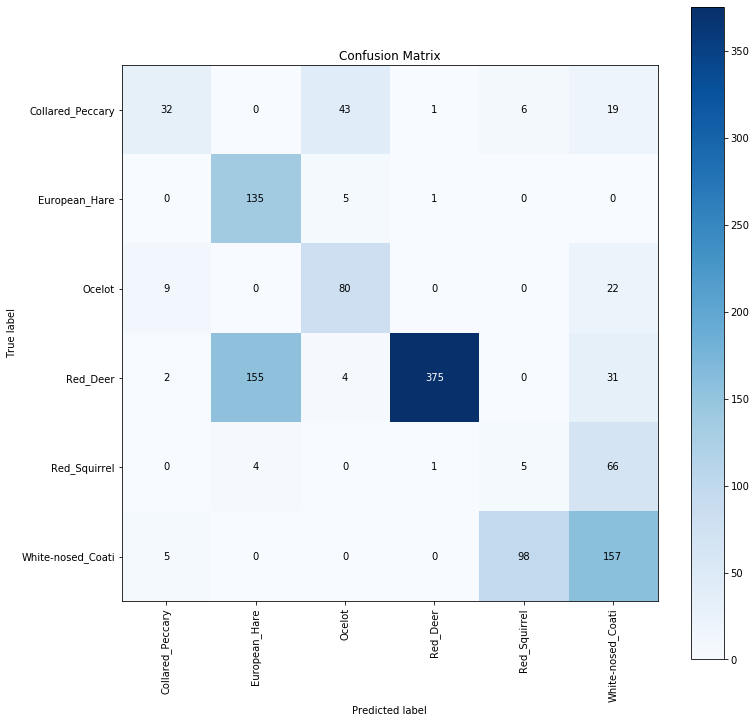

In [19]:
[print(k, ":", v) for k,v in enumerate(class_labels)]
true_map_classes = [class_labels[x] for x in true_classes]
predicted_map_classes = [class_labels[x] for x in predicted_classes]

skplt.metrics.plot_confusion_matrix(
    true_map_classes, 
    predicted_map_classes,
    labels=class_labels,
    x_tick_rotation=90,
    figsize=(12,12))

In [0]:
from sklearn.metrics import classification_report

In [0]:
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels)

In [22]:
print(report)

                   precision    recall  f1-score   support

 Collared_Peccary       0.67      0.32      0.43       101
    European_Hare       0.46      0.96      0.62       141
           Ocelot       0.61      0.72      0.66       111
         Red_Deer       0.99      0.66      0.79       567
     Red_Squirrel       0.05      0.07      0.05        76
White-nosed_Coati       0.53      0.60      0.57       260

         accuracy                           0.62      1256
        macro avg       0.55      0.55      0.52      1256
     weighted avg       0.72      0.62      0.64      1256



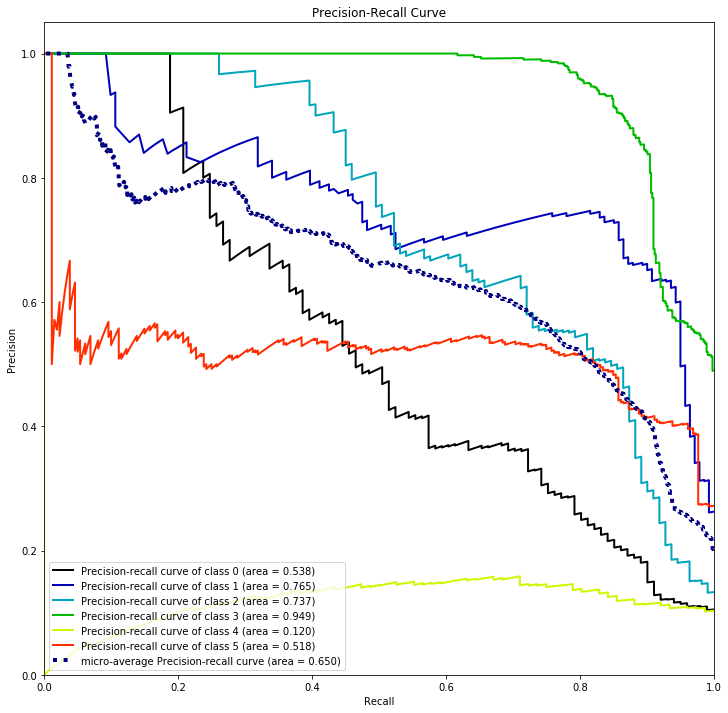

In [23]:
skplt.metrics.plot_precision_recall(
    true_classes,
    predictions,
    figsize=(12,12))

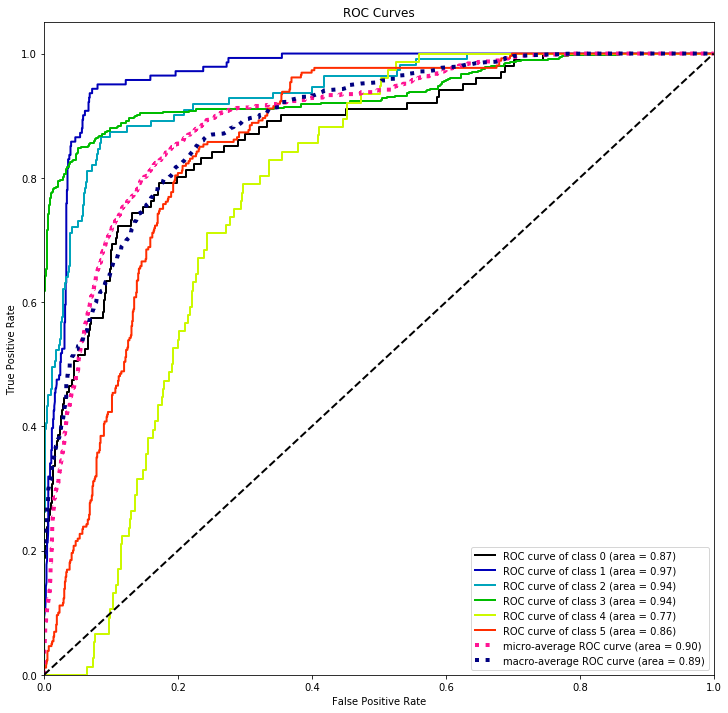

In [24]:
skplt.metrics.plot_roc(
    true_classes,
    predictions,
    figsize=(12,12))